In [1]:
import cv2 as cv2
import os
import glob
import numpy as np
import scipy
from matplotlib import pyplot as plt
import pandas as pd
from google.colab.patches import cv2_imshow

In [2]:
%mkdir video_frames
%cd video_frames

/content/video_frames


In [3]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
files=upload_files()

Saving 108.jpg to 108.jpg
Saving 123.jpg to 123.jpg
Saving 124.jpg to 124.jpg
Saving 125.jpg to 125.jpg
Saving 126.jpg to 126.jpg
Saving 127.jpg to 127.jpg
Saving 0128.jpg to 0128.jpg
Saving 128.jpg to 128.jpg
Saving 0129.jpg to 0129.jpg
Saving 129.jpg to 129.jpg
Saving 130.jpg to 130.jpg
Saving 131.jpg to 131.jpg
Saving 132.jpg to 132.jpg
Saving 133.jpg to 133.jpg
Saving 134.jpg to 134.jpg
Saving 135.jpg to 135.jpg
Saving 136.jpg to 136.jpg
Saving 137.jpg to 137.jpg
Saving 138.jpg to 138.jpg
Saving 139.jpg to 139.jpg
Saving 140.jpg to 140.jpg
Saving 141.jpg to 141.jpg
Saving 142.jpg to 142.jpg
Saving 143.jpg to 143.jpg
Saving 144.jpg to 144.jpg
Saving 145.jpg to 145.jpg
Saving 146.jpg to 146.jpg
Saving 147.jpg to 147.jpg
Saving 148.jpg to 148.jpg
Saving 149.jpg to 149.jpg
Saving 150.jpg to 150.jpg
Saving 151.jpg to 151.jpg
Saving 152.jpg to 152.jpg
Saving 153.jpg to 153.jpg
Saving 154.jpg to 154.jpg
Saving 155.jpg to 155.jpg
Saving 156.jpg to 156.jpg
Saving 157.jpg to 157.jpg


In [4]:
# Read images

def sort_key(filename):
    return int(os.path.splitext(filename)[0])

img_dir="/content/video_frames"
data_path = os.path.join(img_dir,'*jpg')
file_paths = glob.glob(data_path)
filenames = [x.split('/')[-1] for x in file_paths]

sorted_filenames = sorted(filenames, key=sort_key)
f_list = []
count=0
for f1 in sorted_filenames:
    filepath = os.path.join(img_dir, f1)
    count=count+1
    img = cv2.imread(filepath,0)
    f_list.append(cv2.GaussianBlur(img,(5,5),0))

In [5]:
# Subtract background image (i.e., first image from all images)
difference=[]
for i in range(len(f_list)-1):
    diff=cv2.subtract(f_list[i],f_list[i+1])
    difference.append(diff)

In [6]:
# Apply Gaussian Blurr to supress noise

smooth_imgs=[]
for i in range(len(f_list)-1):
   d=cv2.GaussianBlur(difference[i],(5,5),0)
   smooth_imgs.append(d)

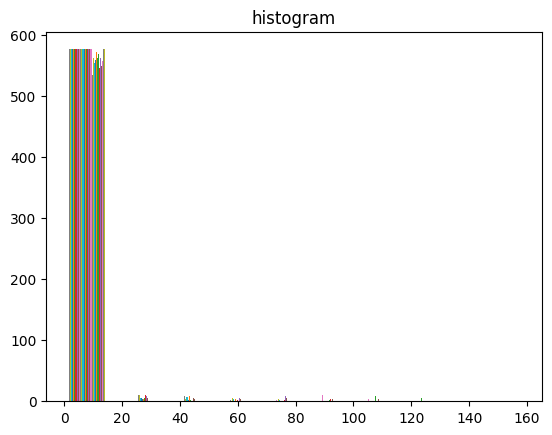

In [7]:
# Visualize Histogram to decide threshold

import numpy as np
a = np.asarray(difference[2])
plt.hist(a, bins = 10)
plt.title("histogram")
plt.show()

In [8]:
# Apply Thresholding to get binary image

thresholded_imgs=[]
for i in range(len(f_list)-1):
    ret,thresh1 = cv2.threshold( smooth_imgs[i],50,255,cv2.THRESH_BINARY)
    thresholded_imgs.append(thresh1)

In [9]:
# Fetch centroidsfrom all binary images

centroids=[]
for k in range(0,len(thresholded_imgs)):
    x=[]
    y=[]
    binary_img=thresholded_imgs[k]
    for j in range(binary_img.shape[0]):
       for i in range(binary_img.shape[1]):
           if binary_img[j][i]==255:
              x.append(i)
              y.append(j)

    if len(x) and len(y):
      centroid=[int(round(sum(x)/len(x))),int(round(sum(y)/len(y)))]
    else:
      centroid = centroid

    centroids.append(centroid)

In [10]:
print(centroids)

[[630, 385], [613, 370], [598, 367], [585, 362], [572, 358], [557, 354], [557, 354], [544, 350], [544, 350], [527, 346], [513, 342], [500, 339], [487, 335], [475, 333], [463, 329], [450, 325], [438, 321], [427, 318], [414, 315], [403, 312], [393, 308], [383, 304], [373, 301], [365, 298], [355, 295], [346, 291], [338, 288], [331, 283], [323, 280], [315, 276], [308, 273], [299, 269], [294, 266], [287, 263], [279, 261], [271, 258], [262, 254]]


In [11]:
#define main variables

import numpy as np
dt = 1                        #our sampling rate
S_frame = 1                   #starting frame
a = 0.005                    # define acceleration magnitude
Q_estimate= np.array([[centroids[1][0]],[centroids[1][1]], [0] ,[0]])   #initized state--it has four components: [positionX; positionY; velocityX; velocityY] of the hexbug
#estimate of initial location estimation of where the car is (what we are updating)
HexAccel_noise_mag = 0.1       #process noise: the variability in how fast the car is speeding up (stdv of acceleration: meters/sec^2)
tkn_x = 1                     #measurement noise in the horizontal direction (x axis).
tkn_y = 1                     #measurement noise in the horizontal direction (y axis).
Ez = np.array([[tkn_x,0] , [0,tkn_y]]) #measurement vector error
Ex = np.array([[dt**4/4, 0 ,dt**3/2 ,0],
              [0, dt**4/4, 0 ,dt**3/2],
              [dt**3/2 ,0, dt**2, 0],
              [0, dt**3/2, 0 ,dt**2]])     #HexAccel_noise_mag^2; % Ex convert the process noise (stdv) into covariance matrix
P = Ex   # estimate of initial car position variance (covariance matrix)
print(Q_estimate)

[[613]
 [370]
 [  0]
 [  0]]


In [12]:
# Define update equations in 2-D! (Coefficent matrices): A physics based model for where we expect the car to be [state transition (state + velocity)] + [input control (acceleration)]
A = np.array([[1, 0 ,dt, 0],[ 0 ,1, 0, dt],[ 0 ,0, 1, 0],[ 0, 0, 0, 1]])    #state update matrice
B = np.array([[(dt**2/2)], [(dt**2/2)], [dt],[ dt]])
C = np.array([[1 ,0, 0 ,0],[ 0 ,1 ,0 ,0]])                                  #this is our measurement function C, that we apply to the state estimate Q to get our expect next/new measurement


In [13]:
# initize result variables
# Initialize for speed

# Q_loc = []  #ACTUAL car motion path
vel = []   # ACTUAL car velocity
Q_loc_meas = []  # the car path extracted by the tracking algo

# initize estimation variables
Q_loc_estimate = []   #  position estimate
vel_estimate = []     # velocity estimate
P_estimate = P
predic_state = []
predic_var = []

In [14]:
# Actual measurement i.e., actual position
Q1=[]
for t in range(len(thresholded_imgs)):                                #instead of 10 write g
    Q1.append([centroids[t][0] ,centroids[t][1]])
Q_loc_meas=np.asarray(Q1)
print(Q_loc_meas.shape)

(37, 2)


In [15]:
#do the kalman filter

estimated_pos=[]
for t in range(0,len(thresholded_imgs)):
  # Predict next state of the car with the last state and predicted motion.
  Q_estimate= np.dot(A,Q_estimate) + B*a

  # predict next covariance
  P = np.dot(A,np.dot(P , np.transpose(A))) + Ex

  # Kalman Gain
  G=np.dot(C,np.dot(P,np.transpose(C)))+Ez
  K=np.dot(P,np.dot(np.transpose(C),np.linalg.inv(G)))
  Q_estimate = Q_estimate + np.dot(K , (np.transpose([Q_loc_meas[t]])- np.dot(C,Q_estimate)))
  print("Estimated state vector={}".format(Q_estimate))

  #update covariance estimation
  I=np.identity(4)
  P=np.dot((I-np.dot(K,C)),P)
  print("Estimated state vector={}".format(P))

  #store data
  Q_loc_estimate=[int(round(Q_estimate[0][0])),int(round(Q_estimate[1][0]))]         #estimated position
  print("Estimated pos vector={}".format(Q_loc_estimate))
  estimated_pos.append(Q_loc_estimate)

  vel_estimate=np.array([[Q_estimate[2][0]],[Q_estimate[3][0]]])                     #estimated velocity
  print("Estimated vel vector={}".format(vel_estimate))

Estimated state vector=[[625.14357143]
 [380.715     ]
 [  9.71785714]
 [  8.575     ]]
Estimated state vector=[[0.71428571 0.         0.57142857 0.        ]
 [0.         0.71428571 0.         0.57142857]
 [0.57142857 0.         0.85714286 0.        ]
 [0.         0.57142857 0.         0.85714286]]
Estimated pos vector=[625, 381]
Estimated vel vector=[[9.71785714]
 [8.575     ]]
Estimated state vector=[[618.51522523]
 [374.86657658]
 [ -0.91364865]
 [ -0.80554054]]
Estimated state vector=[[0.74774775 0.         0.48648649 0.        ]
 [0.         0.74774775 0.         0.48648649]
 [0.48648649 0.         0.91891892 0.        ]
 [0.         0.48648649 0.         0.91891892]]
Estimated pos vector=[619, 375]
Estimated vel vector=[[-0.91364865]
 [-0.80554054]]
Estimated state vector=[[603.04007528]
 [368.81598726]
 [-10.51203532]
 [ -4.26073248]]
Estimated state vector=[[0.74290677 0.         0.48986682 0.        ]
 [0.         0.74290677 0.         0.48986682]
 [0.48986682 0.         0.985

/
mkdir: cannot create directory ‘output’: File exists


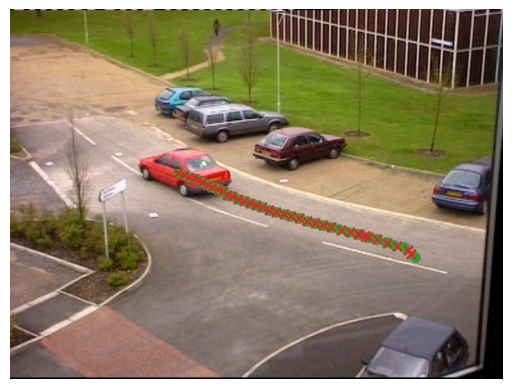

In [22]:
# Visualize output

%cd ..
%mkdir output

output_imgs=[]

i=0
out_dir = '/content/output'
img=cv2.imread(os.path.join(img_dir, sorted_filenames[0]))
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.savefig(os.path.join(out_dir, '{}.jpg'.format(i)), bbox_inches='tight', pad_inches=0)
output_imgs.append(os.path.join(out_dir, '{}.jpg'.format(i)))

for i in range(1, len(sorted_filenames)):
    img=cv2.imread(os.path.join(img_dir, sorted_filenames[i]))
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)
    plt.scatter(*zip(*centroids[:i]), marker='o')              # green - actual
    plt.scatter(*zip(*estimated_pos[:i]), marker='x')          # red - predicted
    plt.savefig(os.path.join(out_dir, '{}.jpg'.format(i)), bbox_inches='tight', pad_inches=0)
    output_imgs.append(os.path.join(out_dir, '{}.jpg'.format(i)))

In [23]:
# Get Video

fps=5
img_array = []
for filename in output_imgs:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

for i in range(len(img_array)):
   out.write(img_array[i])

out.release()

In [24]:
from google.colab import files
files.download('project.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>